In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import split_dataset, create_sequences, root_mean_squared_error, plot_metrics

monthly = pd.read_csv('../../../Dataset/Boulder_Monthly.csv')
monthly.drop(columns={'Unnamed: 0'}, inplace=True)
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   55 non-null     float64
 1   Month          55 non-null     object 
 2   Minimum T      55 non-null     int64  
 3   Maximum T      55 non-null     int64  
 4   Snow           55 non-null     float64
 5   Precipitation  55 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.7+ KB


    Scale the Dataset with MinMaxScaler / One-Hot Encode and Extract the Entire Scaled Dataset

In [85]:
# Define the columns we need to scale and we need to use for One-Hot Encoding
columns_to_scale = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']
categorical_columns = ['Month']

# MinMax scaling for numerical columns and One-hot encoding for categorical columns
scaler = MinMaxScaler()
monthly_scaled = monthly.copy()
monthly_scaled[columns_to_scale] = scaler.fit_transform(monthly[columns_to_scale])

# One-hot encoding for categorical columns
onehot_encoder = OneHotEncoder(sparse=False)
categorical_encoded = onehot_encoder.fit_transform(monthly[categorical_columns])

# Get the feature names from the encoder
encoded_columns = []
for col, values in zip(categorical_columns, onehot_encoder.categories_):
    encoded_columns.extend([f'{col}_{value}' for value in values])

# Create DataFrame with encoded columns
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Concatenate the new encoded columns to the original DataFrame
monthly_scaled = pd.concat([monthly_scaled, categorical_encoded_df], axis=1)

# Drop the original categorical columns
monthly_scaled = monthly_scaled.drop(categorical_columns, axis=1)
monthly_scaled.columns

Index(['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September'],
      dtype='object')

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [86]:
train_monthly_scaled, val_monthly_scaled, test_monthly_scaled = split_dataset(monthly_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.691
Validation split ratio: 0.2
Testing split ratio:    0.109

Shapes of the datasets:
(38, 17) (11, 17) (6, 17)


    Create sequences for the Transformer model

In [87]:
sequence_length = 2
num_features = len(monthly_scaled.columns)

# Create the training, validation, and test data sequences
train_data_inputs, train_data_targets = create_sequences(train_monthly_scaled, sequence_length)
val_data_inputs, val_data_targets = create_sequences(val_monthly_scaled, sequence_length)
test_data_inputs, test_data_targets = create_sequences(test_monthly_scaled, sequence_length)

Dataset split into sequences:
Sequences shape: (36, 2, 17)
Targets shape: (36,)

Dataset split into sequences:
Sequences shape: (9, 2, 17)
Targets shape: (9,)

Dataset split into sequences:
Sequences shape: (4, 2, 17)
Targets shape: (4,)



    Create the Transformer Model

In [88]:
%run "../Time2Vec/Time2Vec_Transformer.ipynb"

In [89]:
# Define the hyperparameters of the model
num_features = len(monthly_scaled.columns)
n_heads = 1
ff_dim = 64
num_layers = 3
d_k = 480 # dimensions of keys
d_v = 480 # dimensions of values

# Create the transformer model
model = Time2VecTranformer(d_k, d_v, n_heads, ff_dim, num_layers, sequence_length, num_features)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2, 17)]      0           []                               
                                                                                                  
 time2_vector_8 (Time2Vector)   (None, 2, 2)         8           ['input_9[0][0]']                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 2, 19)        0           ['input_9[0][0]',                
                                                                  'time2_vector_8[0][0]']         
                                                                                                  
 transformer_encoder_24 (Transf  (None, 2, 19)       40530       ['concatenate_8[0][0]',    

    Compile the Model

In [90]:
# Define the learning rate for Adam optimizer
learning_rate = 0.01

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

    Train the Model

In [91]:
# Define the parameters for training
epochs = 200
batch_size = 1

In [92]:
# Train the model
history = model.fit(
    train_data_inputs, train_data_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_data_inputs, val_data_targets)
)

Epoch 1/200


36/36 [==============================] - 13s 61ms/step - loss: 0.1052 - mae: 0.2537 - mse: 0.1052 - root_mean_squared_error: 0.2537 - val_loss: 0.0528 - val_mae: 0.1721 - val_mse: 0.0528 - val_root_mean_squared_error: 0.1721
Epoch 2/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0845 - mae: 0.2302 - mse: 0.0845 - root_mean_squared_error: 0.2302 - val_loss: 0.0517 - val_mae: 0.1752 - val_mse: 0.0517 - val_root_mean_squared_error: 0.1752
Epoch 3/200
36/36 [==============================] - 1s 14ms/step - loss: 0.0711 - mae: 0.2293 - mse: 0.0711 - root_mean_squared_error: 0.2293 - val_loss: 0.0517 - val_mae: 0.1751 - val_mse: 0.0517 - val_root_mean_squared_error: 0.1751
Epoch 4/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0721 - mae: 0.2162 - mse: 0.0721 - root_mean_squared_error: 0.2162 - val_loss: 0.0519 - val_mae: 0.1707 - val_mse: 0.0519 - val_root_mean_squared_error: 0.1707
Epoch 5/200
36/36 [==============================] - 0s 13ms/step -

    Evaluate the Model

In [93]:
train_eval = model.evaluate(train_data_inputs, train_data_targets, verbose=0)
val_eval = model.evaluate(val_data_inputs, val_data_targets, verbose=0)
test_eval = model.evaluate(test_data_inputs, test_data_targets, verbose=0)

print('\nEvaluation metrics:\n-------------------')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(train_eval[0], train_eval[3], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(val_eval[0], val_eval[3], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[3], test_eval[1], test_eval[2]))


Evaluation metrics:
-------------------
Training Data - Loss: 0.0670, MAE: 0.2527, RMSE: 0.2121, MSE: 0.0670

Validation Data - Loss: 0.0522, MAE: 0.2284, RMSE: 0.1709, MSE: 0.0522

Test Data - Loss: 0.0292, MAE: 0.1708, RMSE: 0.1615, MSE: 0.0292


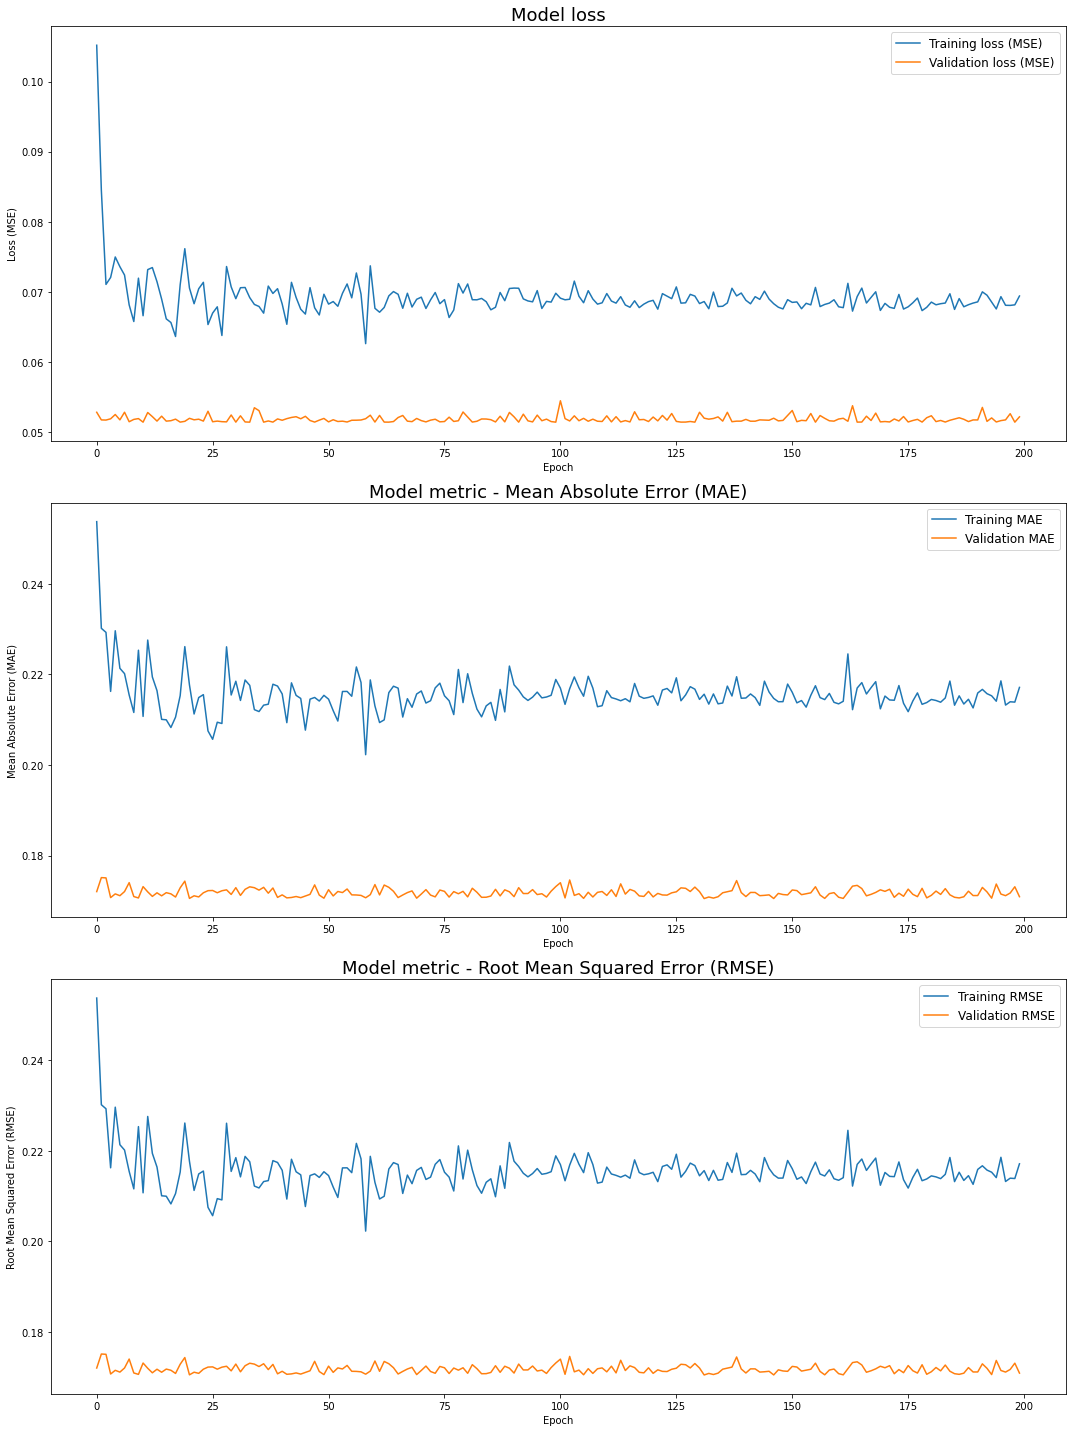

In [94]:
plot_metrics(history)